In [1]:
#The following code is from andrew Ng
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import imageio

%matplotlib inline

C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

In [2]:
import colorsys
import imghdr
import os
import random
from keras import backend as K

import numpy as np
from PIL import Image, ImageDraw, ImageFont

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [3]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.6):
    """Filter the outputted Yolo boxes so only the one with the best score is picked
    (In this implementation, there is 5 anchor box, 19x19 Yolo boxes and 80 classes, 
    so there will be 19x19x5 shape)
    
    
    Arguments:
    box_confidence = a tensor in shape of (19x19x5x1) indicating the Pc of each anchor box
    boxes = a tensor in shape of (19x19x5x4) that will indicate the coordinate of each 
            detected object
    box_class_probs = a tensor in shape of (19x19x5x80) which indicates the percentage
                    of each detected object
    threshold = the percentage where the box_confidence will be kept, otherwise it will be
                discarded and not evaluated (kept if threshold >= scores, which is Pc * highest prob)
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    indices -- tensor of shape (None,), containing the index of the class detected by the selected boxes

                
    """
    #count the scores of each box first
    scoresTemp = box_confidence*box_class_probs #19x19x5x80 of scores
    
    #only take the max of each class
    indices = K.argmax(scoresTemp, axis = -1)
    box_class_probs = K.max(scoresTemp, axis = -1)
    
    keptTrueFalse = box_class_probs >= threshold #19x19x5
    
    scores = tf.boolean_mask(box_class_probs, keptTrueFalse)
    boxes = tf.boolean_mask(boxes, keptTrueFalse)
    indices = tf.boolean_mask(indices,keptTrueFalse) #shape will be (None, 80)
    
    return scores, boxes, indices

In [4]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


In [5]:
def iou(box1, box2):
    """This function will be used to find the amount of Intersection/Union. Value will be 0 if no intersection (even only
    intersect at the edges)
    
    Argumets:
    box1 = list with coordinate of (box1_topleft_x, box1_topleft_y, box1_bottomright_x, box1_bottomright_y)
    box2 = list with coordinate of (box2_topleft_x, box2_topleft_y, box2_bottomright_x, box2_bottomright_y)
    
    Return result:
    iou = the value of Intersection+Union"""
    
    box1_topleft_x, box1_topleft_y, box1_bottomright_x, box1_bottomright_y = box1[0], box1[1],box1[2],box1[3]
    box2_topleft_x, box2_topleft_y, box2_bottomright_x, box2_bottomright_y = box2[0], box2[1],box2[2],box2[3]
    #find the intersection first, will be false if the coordinate end up as the top-right and/or bottom-left of the intersection
    intersectionTopLeftX = max(box1_topleft_x, box2_topleft_x)
    intersectionTopLeftY = max(box1_topleft_y, box2_topleft_y)
    intersectionBottomRightX = min(box1_bottomright_x, box2_bottomright_x)
    intersectionBottomRightY = min(box1_bottomright_y, box2_bottomright_y)
    width = intersectionBottomRightX - intersectionTopLeftX
    height = intersectionBottomRightY - intersectionTopLeftY
    i = max(height,0)*max(width,0)
    allArea = (box1_bottomright_y - box1_topleft_y)*(box1_bottomright_x - box1_topleft_x) + (box2_bottomright_y - box2_topleft_y)*(box2_bottomright_x - box2_topleft_x)
    u = allArea - i
    iou = i/u
    #print(f"i = {i}, u = {u}")
    return iou

In [6]:
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou for intersecting boxes = " + str(iou(box1, box2)))

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0


In [7]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies the non max suppresion algorithm to:
    1. Select the box with the highest score
    2. Compute the IoU of this box with the others, if (iou >= iou_threshold), remove the box
    3. Go back to step 1 until there are no longer lower score boxes
    
    *non_max_suppression will use tf.image.non_max_suppression(boxes, scores, max_output_size, iou_threshold = 0.5, name = None) and 
    keras.gather(reference, indices)
    
    Arguments:
    scores = tensor in shape of (None,), output of yolo_filter_boxes
    boxes = tensor in shape of (None,4), output of yolo_filter_boxes
    classes = tensor in shape of (None,), output of yolo_filter_boxes
    max_boxes = integer, maximum number of predicted boxes that is preffered
    iou_threshold = real, IOU threshold for non max suppresion filtering
    
    Returns:
    scores = tensor of shape (,None), predicted score for eeach box
    boxes = tensor of shape (4,None), predicted box coordinates
    classes = tensor of shape (,None), predicted class for each box
    
    *None must be lower than the max_boxes. Output is transposed dimension of the input for convenience (as a result of keras.gather)."""
    
    #convert the max_boxes to max_boxes_tensor
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))#intialize variable
    
    #find the indices of the box to keep with the tf.image.non_max_suppresion
    keepIndices = tf.image.non_max_suppression(boxes, scores, max_output_size = max_boxes_tensor, iou_threshold = iou_threshold)
    
    #from the retrieved index, use it to only select the scores, boxes, and classes based on the chosen index
    scores = K.gather(scores,keepIndices)
    boxes = K.gather(boxes,keepIndices)
    classes = K.gather(classes,keepIndices)
    
    return scores,boxes,classes

In [8]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [9]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes = 10, score_threshold = .6, iou_threshold = .5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    
    *Yolo default model take input shape of 608x608, different size of image will be resized, hence the output boxes should also be resized.
    """
    
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    
    #Convert to corner coordinates
    boxes_corners = yolo_boxes_to_corners(box_xy, box_wh)
    
    #perform score filtering
    scores,boxes,classes = yolo_filter_boxes(box_confidence, boxes_corners, box_class_probs, score_threshold)
    
    #scale back to original shape
    boxes=scale_boxes(boxes, image_shape) #result will be keras tensor of [ymin,xmin,ymax,xmax]
    
    #evaluate iou of each box after converting it into original shape
    scores,boxes,classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores,boxes,classes
    

In [10]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [47]:
#defining the class names and anchors
sess = K.get_session()
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolov2-tiny_anchors.txt")
print(anchors)
image_shape = (720., 1280.)    

[[0.57273  0.677385]
 [1.87446  2.06253 ]
 [3.33843  5.47434 ]
 [7.88282  3.52778 ]
 [9.77052  9.16828 ]]


In [48]:
yolo_model = load_model("model_data/yolov2-tiny.h5")

In [49]:
yolo_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128 

In [50]:
#using the yad2k program
print(type(yolo_model.output))
print((yolo_model.output))
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names)) #convert output of the model to usable bounding box tensors
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape) #filtering and choosing the best boxes

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("conv2d_9_4/BiasAdd:0", shape=(?, 13, 13, 425), dtype=float32)


In [51]:
#for prediction of an image
def predict(sess, image_file):
    """After arranging the graph of the desired yolo version, now this function will be used to predict the final image output
    
    Arguments:
    sess = tensorflow session containing the graph of the Yolo
    image_file = the image that is desired to be predicted
    
    output:
    out_scores = tensor shape (None, ), scores of the predicted boxes
    out_boxes = tensor of shape(None, 4), coordinates of the predicted boxes
    out_classes = tensor of shape (None, ), class index of thee predicted boxes
    
    
    None = amount of the predicted boxes, ranging from 0 - max_boxes
    by default, max_boxes will be set to 10 in this function"""
    
    #preprocess the image with Andrew Ng function
    path = "images/"+image_file
    image, image_data = preprocess_image(path, model_image_size = (608,608)) #608x608 is defaultly used inside this model
    
    #run the session with sess.run
    out_scores, out_boxes, out_classes = sess.run([scores,boxes,classes], feed_dict = {yolo_model.input:image_data, K.learning_phase():0})
    #learning phase 0 means test, learning phase 1 means train
    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    
    return out_scores, out_boxes, out_classes

In [52]:
#make the predict function as a function to gather every previous function

def anotherpredict(sess, imagePath, classList):
    """Arrange everything inside this function.
    
    Arguments:
    sess = the previous K.get_session() that contains the model
    imagePath = the file path of the image, not included with the 'images/' folder directory
    
    Returns:
    output_image = PIL.Image.open() of the result image including the added scores, boxes and classes
    out_scores = tensor shape (None, ), scores of the predicted boxes
    out_boxes = tensor of shape(None, 4), coordinates of the predicted boxes
    out_classes = tensor of shape (None, ), class index of thee predicted boxes
    
    
    None = amount of the predicted boxes, ranging from 0 - max_boxes
    by default, max_boxes will be set to 10 in this function"""
    
    readPath = "images/"+imagePath
    #preprocess the image first, return the copy of the same image and the data of the image
    img, imgData = preprocess_image(readPath, (416,416))
    
    #run the session to get the scores, boxes, and classes
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict= {yolo_model.input : imgData, K.learning_phase():0})
    #create the list of color needed for the classes
    colors = generate_colors(class_names)
    
    #draw the boxes based on the generated colors
    draw_boxes(img,out_scores, out_boxes, out_classes, class_names, colors)
    
    #save the image on the output folder
    img.save(os.path.join("out", imagePath), quality=90)
    
    output_image = Image.open(os.path.join("out", imagePath))
    imshow(output_image)
    
    #optional, return the image
    return output_image, out_scores, out_boxes, out_classes

car 0.70 (328, 304) (362, 325)
car 0.70 (432, 295) (460, 311)
car 0.77 (135, 308) (189, 334)
car 0.80 (235, 307) (274, 335)
car 0.83 (536, 292) (569, 309)
car 0.89 (713, 290) (744, 308)
car 0.90 (620, 293) (660, 309)
[0.89994055 0.88804966 0.82837653 0.80152565 0.76898724 0.70382446
 0.70291454]
traffic light 0.62 (732, 249) (750, 266)
person 0.72 (890, 261) (964, 369)
car 0.75 (118, 297) (177, 334)
car 0.83 (309, 295) (377, 328)
car 0.85 (218, 298) (272, 335)
car 0.87 (784, 286) (844, 318)
car 0.88 (630, 288) (659, 306)
car 0.90 (718, 287) (755, 307)
car 0.91 (417, 293) (470, 316)
car 0.94 (520, 292) (563, 312)
[0.93824977 0.9127863  0.89705956 0.8797615  0.865295   0.8469949
 0.8270832  0.746894   0.72278714 0.6181605 ]
car 0.62 (618, 297) (646, 321)
car 0.73 (217, 324) (287, 367)
car 0.77 (125, 295) (166, 322)
car 0.79 (530, 289) (550, 306)
car 0.83 (699, 289) (756, 314)
car 0.85 (218, 300) (280, 333)
car 0.91 (318, 298) (370, 325)
car 0.92 (423, 292) (461, 316)
[0.91671246 0.912473

KeyboardInterrupt: 

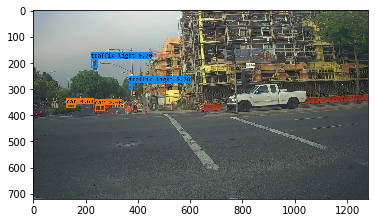

In [53]:
for i in os.listdir("images"):
    output_image, out_scores, out_boxes, out_classes = anotherpredict(sess, i,class_names)
    print(out_scores)